In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Exercise 3

### Question A

In [2]:
x = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([[0],
              [1],
              [1],
              [0]])

In [3]:
df = pd.DataFrame(np.concatenate((x, y), axis=1), columns=('x1', 'x2', 'y'))
df.style.hide()

x1,x2,y
0,0,0
0,1,1
1,0,1
1,1,0


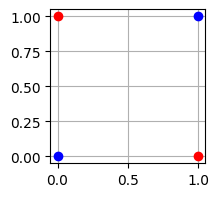

In [4]:
plt.figure(figsize=(2,2))

plt.plot(*x[0], 'o', color='blue')
plt.plot(*x[1], 'o', color='red')
plt.plot(*x[2], 'o', color='red')
plt.plot(*x[3], 'o', color='blue')
plt.grid()

plt.show()

In [5]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, one_hot=False):
        # Initialize number of nodes of input, hidden, and output layer
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size


        # Initialize weights (w) and biases (b)
        # input -> hidden
        self.w1 = np.random.rand(self.input_size, self.hidden_size) # 35*10
        self.b1 = np.zeros((1, self.hidden_size)) # 1*10

        # hidden -> output
        self.w2 = np.random.rand(self.hidden_size, self.output_size) # 10*1
        self.b2 = np.zeros((1, self.output_size)) # 1*1

        #adam parameters
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

        # Increment the time step
        self.t =0

        
        # Use of one_hot encoding
        self.one_hot = one_hot
        
       # Initialize moving average variables for weights
        self.m_w1 = np.zeros_like(self.w1)
        self.v_w1 = np.zeros_like(self.w1)
        self.m_w2 = np.zeros_like(self.w2)
        self.v_w2 = np.zeros_like(self.w2)

        # Initialize moving average variables for biases
        self.m_b1 = np.zeros_like(self.b1)
        self.v_b1 = np.zeros_like(self.b1)
        self.m_b2 = np.zeros_like(self.b2)
        self.v_b2 = np.zeros_like(self.b2)
    

    def sigmoid(self, x, deriv=False):
        """Sigmoid activation function"""
        if deriv:
            return self.sigmoid(x) * (1 - self.sigmoid(x))
        return 1 / (1 + np.exp(-x))



    def one_hot_encoding(self, y):
        """Encode digit to one-hot (used in error calculation of backpropagation)"""
        y = y.reshape(-1, 10)
        encoded_y = np.zeros((y.size, y.max() + 1))
        encoded_y[np.arange(y.size), y.flatten()] = 1
        encoded_y = encoded_y.T
        return encoded_y


    def feedforward(self, x):
        """Feedforward"""
        # input -> hidden
        self.z1 = np.dot(x, self.w1) + self.b1 # 10*35 @ 35*10 = 10*10
        self.a1 = self.sigmoid(self.z1)



        # hidden -> output
        self.z2 = np.dot(self.a1, self.w2) + self.b2 # 10*10 @ 10*1 = 10*1
        self.a2 = self.sigmoid(self.z2) # 10*1

        #self.a2 = self.softmax(self.z2)

        return self.a2

    #def softmax(self, x):
        """Stable softmax activation function"""
        #e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        #return e_x / np.sum(e_x, axis=1, keepdims=True)

    def backpropagation(self, x, y, learning_rate):
        """Backpropagation"""        
        self.m = y.size
        
        self.d_z2 = self.a2 - y # 10*1
        self.d_w2 = np.dot(self.a1.T, self.d_z2) / self.m # 10*10 @ 10*1 = 10*1
        self.d_b2 = np.sum(self.d_z2) / self.m # 1*1
        
        self.d_z1 = np.dot(self.d_z2, self.w2.T) * self.sigmoid(self.z1, deriv=True) # 10*1 @ 1*10
        self.d_w1 = np.dot(x.T, self.d_z1) / self.m
        self.d_b1 = np.sum(self.d_z1) / self.m

        #updating adam parameters m = beta1 * m + (1 - beta1) * d_ and v = beta2 * v + (1 - beta2) * (d_ ** 2)
        self.m_w1 = self.beta1 * self.m_w1 + (1 - self.beta1) * self.d_w1
        self.v_w1 = self.beta2 * self.v_w1 + (1 - self.beta2) * (self.d_w1 ** 2)
        self.m_b1 = self.beta1 * self.m_b1 + (1 - self.beta1) * self.d_b1
        self.v_b1 = self.beta2 * self.v_b1 + (1 - self.beta2) * (self.d_b1 ** 2)
        self.m_w2 = self.beta1 * self.m_w2 + (1 - self.beta1) * self.d_w2
        self.v_w2 = self.beta2 * self.v_w2 + (1 - self.beta2) * (self.d_w2 ** 2)
        self.m_b2 = self.beta1 * self.m_b2 + (1 - self.beta1) * self.d_b2
        self.v_b2 = self.beta2 * self.v_b2 + (1 - self.beta2) * (self.d_b2 ** 2)

        #bias corrections average
        m_w1_hat = self.m_w1 / (1 - self.beta1)
        v_w1_hat = self.v_w1 / (1 - self.beta2)
        m_b1_hat = self.m_b1 / (1 - self.beta1)
        v_b1_hat = self.v_b1 / (1 - self.beta2)
        m_w2_hat = self.m_w2 / (1 - self.beta1)
        v_w2_hat = self.v_w2 / (1 - self.beta2)
        m_b2_hat = self.m_b2 / (1 - self.beta1)
        v_b2_hat = self.v_b2 / (1 - self.beta2)

        #updating bias and weights 
        self.w1 -= m_w1_hat * learning_rate /(np.sqrt(v_w1_hat)+ self.epsilon)
        self.b1 -= m_b1_hat * learning_rate /(np.sqrt(v_b1_hat)+ self.epsilon)
        self.w2 -= m_w2_hat * learning_rate /(np.sqrt(v_w2_hat)+ self.epsilon)
        self.b2 -= m_b2_hat * learning_rate /(np.sqrt(v_b2_hat)+ self.epsilon)

    

    def train(self, x, y, learning_rate, epochs):
        """Optimize weight and bias parameters for adam""" 

        if self.one_hot:
            y = self.one_hot_encoding(y)

        for epoch in range(epochs):
            self.feedforward(x)
            self.backpropagation(x, y, learning_rate)

            if not epoch % (epochs / 10):
                loss = self.cross_entropy_loss(y, self.a2)
                print(f'Epoch {epoch}: {loss}')
            
            self.update_adam()


    def cross_entropy_loss(self, y_true, y_pred):
        """Calculate categorical cross-entropy loss"""
        epsilon = 1e-10  # Small value to prevent log(0) cases
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predictions to avoid log(0)
        m = y_true.shape[0]  # Number of examples
        loss = -np.sum(y_true * np.log(y_pred_clipped)) / m
        return loss

    def update_adam(self):
        # Update variables
        self.m_w1 = self.beta1 * self.m_w1 + (1 - self.beta1) * self.d_w1
        self.v_w1 = self.beta2 * self.v_w1 + (1 - self.beta2) * (self.d_w1 ** 2)
        self.m_b1 = self.beta1 * self.m_b1 + (1 - self.beta1) * self.d_b1
        self.v_b1 = self.beta2 * self.v_b1 + (1 - self.beta2) * (self.d_b1 ** 2)
        self.m_w2 = self.beta1 * self.m_w2 + (1 - self.beta1) * self.d_w2
        self.v_w2 = self.beta2 * self.v_w2 + (1 - self.beta2) * (self.d_w2 ** 2)
        self.m_b2 = self.beta1 * self.m_b2 + (1 - self.beta1) * self.d_b2
        self.v_b2 = self.beta2 * self.v_b2 + (1 - self.beta2) * (self.d_b2 ** 2)
    

        self.t += 1 
        
        # Bias correction for m and v variables
        self.m_w1_hat = self.m_w1 / (1 - self.beta1 ** self.t)
        self.m_w2_hat = self.m_w2 / (1 - self.beta1 ** self.t)
        self.m_b1_hat = self.m_b1 / (1 - self.beta1 ** self.t)
        self.m_b2_hat = self.m_b2 / (1 - self.beta1 ** self.t)
        self.v_w1_hat = self.v_w1 / (1 - self.beta2 ** self.t)
        self.v_w2_hat = self.v_w2 / (1 - self.beta2 ** self.t)
        self.v_b1_hat = self.v_b1 / (1 - self.beta2 ** self.t)
        self.v_b2_hat = self.v_b2 / (1 - self.beta2 ** self.t)

    
        # Update weights and biases with bias correction
        self.w1 -= self.m_w1_hat * learning_rate / (np.sqrt(self.v_w1_hat) + self.epsilon)
        self.w2 -= self.m_w2_hat * learning_rate / (np.sqrt(self.v_w2_hat) + self.epsilon)
        self.b1 -= self.m_b1_hat * learning_rate / (np.sqrt(self.v_b1_hat) + self.epsilon)
        self.b2 -= self.m_b2_hat * learning_rate / (np.sqrt(self.v_b2_hat) + self.epsilon)
        
    def predict(self, x):
        """Get feedforward result with current parameters"""
        return self.feedforward(x)

In [6]:
learning_rate = 0.1
epochs = 10000
nn_A = NeuralNetwork(2, 2, 1)
nn_A.train(x, y, learning_rate, epochs)
nn_A.predict(x)

Epoch 0: 0.3072179426850221
Epoch 1000: 0.17335662898354956
Epoch 2000: 0.1733013246093166
Epoch 3000: 0.17327909619191897
Epoch 4000: 0.17348135535494624
Epoch 5000: 0.17507564710912377
Epoch 6000: 0.17072492542820694
Epoch 7000: 0.17438330417545556
Epoch 8000: 0.1749464619552977
Epoch 9000: 0.17065164635117844


array([[4.96780695e-01],
       [4.96780690e-01],
       [9.99999992e-01],
       [7.40725908e-09]])

### Question B

Load raw data

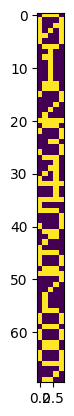

In [7]:
data = np.loadtxt("TP3-ej3-digitos.txt", dtype=np.uint8) 
plt.imshow(data);

Flatten data

In [8]:
data_flattened = data.flatten()
data_flattened = np.reshape(data_flattened, (10, 35))

print(data_flattened.shape)
data_flattened

(10, 35)


array([[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 1

Initialize x input (flattened digit) and y output (result of whether digit is pair)

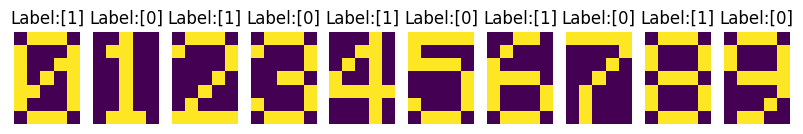

In [9]:
x = data_flattened
y = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)

plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [10]:
input_size = 35
hidden_size = 10
output_size = 1

learning_rate = 0.1
epochs = 10000

nn_B = NeuralNetwork(input_size, hidden_size, output_size)
nn_B.train(x, y, learning_rate, epochs)
nn_B.predict(x)

Epoch 0: 0.006090190395419373
Epoch 1000: 6.631494507950603e-05
Epoch 2000: 1.5140253793094617e-05
Epoch 3000: 4.6930181994668645e-06
Epoch 4000: 1.6105178616728842e-06
Epoch 5000: 5.753828832931963e-07
Epoch 6000: 2.0903215063590229e-07
Epoch 7000: 7.647743231638841e-08
Epoch 8000: 2.806616072944603e-08
Epoch 9000: 1.0315998784085208e-08


array([[9.99999993e-01],
       [9.56682066e-09],
       [9.99999992e-01],
       [1.03401046e-08],
       [9.99999993e-01],
       [9.55188088e-09],
       [9.99999993e-01],
       [9.58285760e-09],
       [9.99999992e-01],
       [9.79273931e-09]])

digit is even: [[1.03401046e-08]]


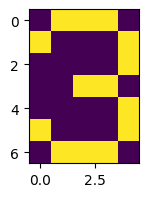

In [11]:
digit = 3

plt.figure(figsize=(2,2))
plt.imshow(np.reshape(data_flattened[digit], (7,5)));
res = nn_B.predict(data_flattened[digit])
print('digit is even:', res)

In [12]:
threshold = 0.5
res = nn_B.predict(data_flattened[digit])
is_even = res > threshold
print(f'The digit is even: {is_even}')

The digit is even: [[False]]


### Exercise C

Initialize data
- x: 10*35 (10 digits * 35 pixels each)
- y: 10*1 (can be classified to 10 possible digits)

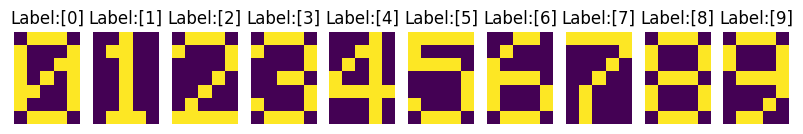

In [13]:
x = data_flattened
y = np.arange(10).reshape(-1, 1)


plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [14]:
input_size = 35
hidden_size = 10
output_size = 10

learning_rate = 0.1
epochs = 100000

nn_C = NeuralNetwork(input_size, hidden_size, output_size, one_hot=True)
nn_C.train(x, y, learning_rate, epochs)
nn_C.predict(x)

Epoch 0: 0.011110554128110026
Epoch 10000: 6.791252397965732e-05
Epoch 20000: 1.0740387860853052e-08
Epoch 30000: 3.681634109924588e-10
Epoch 40000: 1.8371695278807238e-10
Epoch 50000: 1.3696210833370786e-10
Epoch 60000: 1.0866689770844637e-10
Epoch 70000: 1.0113749838126726e-10
Epoch 80000: 1.000000082790371e-10
Epoch 90000: 1.000000082790371e-10


array([[1.00000000e+00, 1.43941770e-26, 4.75329708e-30, 1.96109066e-24,
        6.31017973e-12, 5.29308281e-12, 3.85605368e-13, 1.56750753e-11,
        2.41645267e-11, 9.84355274e-33],
       [2.65146951e-45, 1.00000000e+00, 4.47296966e-12, 2.58428488e-24,
        4.84217790e-12, 1.16051032e-30, 6.28746790e-12, 4.11087476e-12,
        6.08590353e-33, 3.05852183e-44],
       [6.61134261e-51, 8.33687402e-13, 1.00000000e+00, 2.26864911e-12,
        1.24044543e-28, 2.14591617e-12, 2.80929214e-26, 7.65967378e-12,
        1.08168021e-31, 7.65569681e-12],
       [7.49886360e-17, 3.30862374e-26, 7.81362849e-14, 1.00000000e+00,
        5.56612422e-30, 7.67578923e-13, 3.08312618e-20, 3.32799470e-36,
        3.70052154e-19, 3.44624168e-31],
       [1.34624404e-12, 7.48016994e-13, 4.79914111e-32, 4.23537212e-34,
        1.00000000e+00, 6.18504571e-21, 1.88347296e-18, 4.38950025e-19,
        3.72918953e-12, 1.81218721e-14],
       [1.21067040e-11, 5.22905853e-35, 8.66492433e-19, 5.58396934e-20,
   

[[3.79770972e-26 2.06608861e-23 1.25688685e-22 2.12889423e-31
  1.66826850e-16 8.28476576e-20 1.00000000e+00 6.03423834e-29
  9.46840385e-12 6.88630538e-12]]
digit is: 6


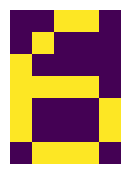

In [15]:
digit = 6

plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(np.reshape(data_flattened[digit], (7,5)));
res = nn_C.predict(data_flattened[digit])
print(res)
print('digit is:', np.argmax(res))

In [16]:
def salt_pepper_noise(img, salt_probability, pepper_probability):
    img_copy = np.copy(img)
    salt = np.random.rand(img.size) < salt_probability
    pepper = np.random.rand(img.size) < pepper_probability
    img_copy[salt] = 1
    img_copy[pepper] = 0
    return img_copy

def random_noise(img):
    img_copy = np.copy(img)
    img_copy = img_copy + np.random.rand(img_copy.size)
    return img_copy

def gaussian_noise(img, mean, std):
    img_copy = np.copy(img)
    img_copy = img_copy + np.random.normal(mean, std, img_copy.size)
    return img_copy

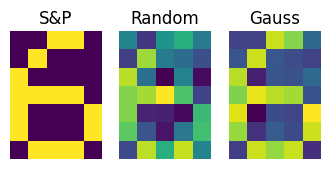

In [17]:
salt_pepper_digit = salt_pepper_noise(data_flattened[digit], 0.05, 0.05)
random_digit = random_noise(data_flattened[digit])
gauss_digit = gaussian_noise(data_flattened[digit], 0.1, 0.1)

noised_data = [salt_pepper_digit, random_digit, gauss_digit]
titles = ['S&P', 'Random', 'Gauss']

plt.figure(figsize=(4,3))
for i, img in enumerate(noised_data):
    plt.subplot(1, 3, i+1)
    plt.title(titles[i])
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)));

In [18]:
np.argmax(nn_C.predict(random_digit))

6